In [1]:
from chromatic_fitting import *
import celerite2
from celerite2.theano import terms, GaussianProcess

Running chromatic_fitting v0.11.1!

This program is running on:
Python v3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
numpy v1.21.6
chromatic v0.4.5
pymc3 v3.11.4
pymc3_ext v0.1.1
exoplanet v0.5.3


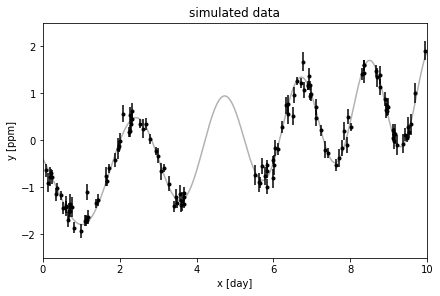

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

t = np.sort(
    np.append(
        np.random.uniform(0, 3.8, 57),
        np.random.uniform(5.5, 10, 68),
    )
)  # The input coordinates must be sorted
yerr = np.random.uniform(0.08, 0.22, len(t))
y = (
    0.2 * (t - 5)
    + np.sin(3 * t + 0.1 * (t - 5) ** 2)
    + yerr * np.random.randn(len(t))
)

true_t = np.linspace(0, 10, 500)
true_y = 0.2 * (true_t - 5) + np.sin(3 * true_t + 0.1 * (true_t - 5) ** 2)

plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)
_ = plt.title("simulated data")

🌈🤖 The time scale for this rainbow is '?',
and there are 125 time centers and
125 time edges defined.

It's hard to imshow something with a time axis
that isn't linearly or logarithmically uniform, or doesn't
at least have its time edges defined. We're giving up
and just using the time index as the time axis.

If you want a real time axis, one solution would
be to bin your times to a more uniform grid with
`rainbow.bin(dt=...)` (for linear times).



<Axes: xlabel='Time Index', ylabel='log$_{10}$[Wavelength/($\\mathrm{\\mu m}$)]'>

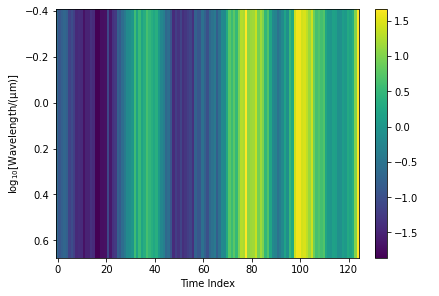

In [3]:
r = SimulatedRainbow(time=t*u.day, R=2)
r.flux *= y
r.uncertainty[:,:] = yerr
r.imshow()

In [4]:
r

<Simulated🌈(5w, 125t)>

In [5]:
# set up polynomial model:
p1 = GPModel(kernel='sho', name='periodic')

p1.setup_parameters(
    sigma = WavelikeFitted(Normal,mu=1, sigma=100),
    rho = Fitted(Normal,mu=1, sigma=100),
    tau = Fitted(Normal,mu=1, sigma=100),
)
p1.summarize_parameters()

# print a summary of all params:
# p1.summarize_parameters()

periodic_sigma =
  <🧮 WavelikeFitted Normal(mu=1, sigma=100, name='periodic_sigma') for each wavelength 🧮>

periodic_rho =
  <🧮 Fitted Normal(mu=1, sigma=100, name='periodic_rho') 🧮>

periodic_tau =
  <🧮 Fitted Normal(mu=1, sigma=100, name='periodic_tau') 🧮>



In [6]:
# set up polynomial model:
p2 = GPModel(kernel='sho', name='nonperiodic')

p2.setup_parameters(
    sigma = Fitted(Normal,mu=1, sigma=100),
    rho = Fitted(Normal,mu=1, sigma=100),
    Q = 0.25,
)

# print a summary of all params:
p2.summarize_parameters()

nonperiodic_sigma =
  <🧮 Fitted Normal(mu=1, sigma=100, name='nonperiodic_sigma') 🧮>

nonperiodic_rho =
  <🧮 Fitted Normal(mu=1, sigma=100, name='nonperiodic_rho') 🧮>

nonperiodic_Q =
  <🧮 Fixed | 0.25 🧮>



In [12]:
p = p1 + p2

/Users/catrionamurray/opt/anaconda3/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:166: UserWarning: periodic in the parameter name: periodic_sigma. Please avoid having the model name in the parameter name as it can get confusing!
  warnings.warn(
/Users/catrionamurray/opt/anaconda3/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:166: UserWarning: nonperiodic in the parameter name: nonperiodic_sigma. Please avoid having the model name in the parameter name as it can get confusing!
  warnings.warn(


In [13]:
p

<chromatic combined model 'combined' 🌈, models: <chromatic GP model 'periodic', with sho kernel 🌈> + <chromatic GP model 'nonperiodic', with sho kernel 🌈>

In [14]:
p.attach_data(r)

In [15]:
p.add_jitter(Fitted(Normal,name='log_jitter', mu=0, sigma=3))

In [16]:
p.setup_lightcurves()

/Users/catrionamurray/opt/anaconda3/lib/python3.9/site-packages/chromatic_fitting/models/gp.py:99: UserWarning: 
You have not provided a mean to the GP. Are you sure this is right?
If you want to add a mean please run {self}.add_mean. We will proceed assuming a mean of 0.

  warnings.warn(


{'sigma': Subtensor{int64}.0, 'rho': Subtensor{int64}.0, 'tau': Subtensor{int64}.0}
{'sigma': Subtensor{int64}.0, 'rho': Subtensor{int64}.0, 'tau': Subtensor{int64}.0}
{'sigma': Subtensor{int64}.0, 'rho': Subtensor{int64}.0, 'tau': Subtensor{int64}.0}
{'sigma': Subtensor{int64}.0, 'rho': Subtensor{int64}.0, 'tau': Subtensor{int64}.0}
{'sigma': Subtensor{int64}.0, 'rho': Subtensor{int64}.0, 'tau': Subtensor{int64}.0}


/Users/catrionamurray/opt/anaconda3/lib/python3.9/site-packages/chromatic_fitting/models/gp.py:99: UserWarning: 
You have not provided a mean to the GP. Are you sure this is right?
If you want to add a mean please run {self}.add_mean. We will proceed assuming a mean of 0.

  warnings.warn(


{'sigma': Subtensor{int64}.0, 'rho': Subtensor{int64}.0, 'Q': 0.25}


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0


{'sigma': Subtensor{int64}.0, 'rho': Subtensor{int64}.0, 'Q': 0.25}


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0


{'sigma': Subtensor{int64}.0, 'rho': Subtensor{int64}.0, 'Q': 0.25}


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0


{'sigma': Subtensor{int64}.0, 'rho': Subtensor{int64}.0, 'Q': 0.25}


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0


{'sigma': Subtensor{int64}.0, 'rho': Subtensor{int64}.0, 'Q': 0.25}


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0


In [17]:
print(p._pymc3_model)

   periodic_sigma ~ Normal
     periodic_rho ~ Normal
     periodic_tau ~ Normal
       log_jitter ~ Normal
nonperiodic_sigma ~ Normal
  nonperiodic_rho ~ Normal


In [18]:
p.setup_likelihood()

/Users/catrionamurray/opt/anaconda3/lib/python3.9/site-packages/chromatic_fitting/models/combined.py:508: UserWarning: 
You have not provided a mean to the GP. Are you sure this is right?
If you want to add a mean please run {self}.add_mean. We will proceed assuming a mean of 0.

  warnings.warn(


optimizing logp for variables: [nonperiodic_rho, nonperiodic_sigma, log_jitter, periodic_tau, periodic_rho, periodic_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: -820.422812331942 -> -22.791462380009634


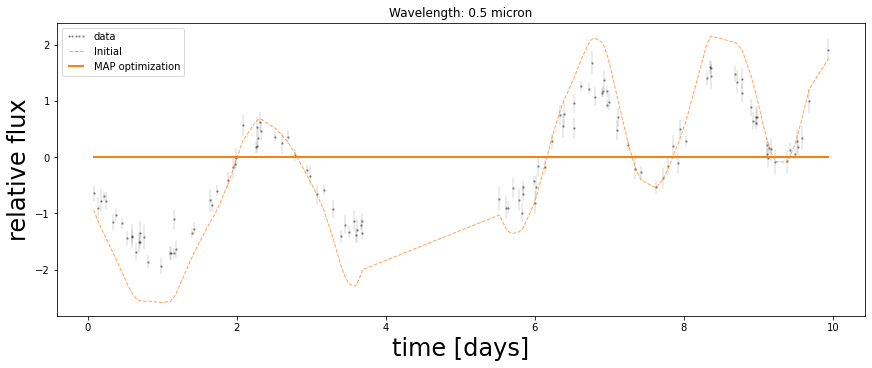

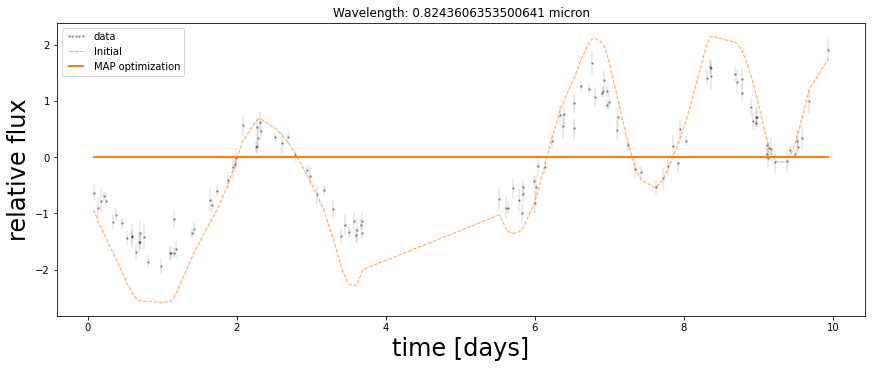

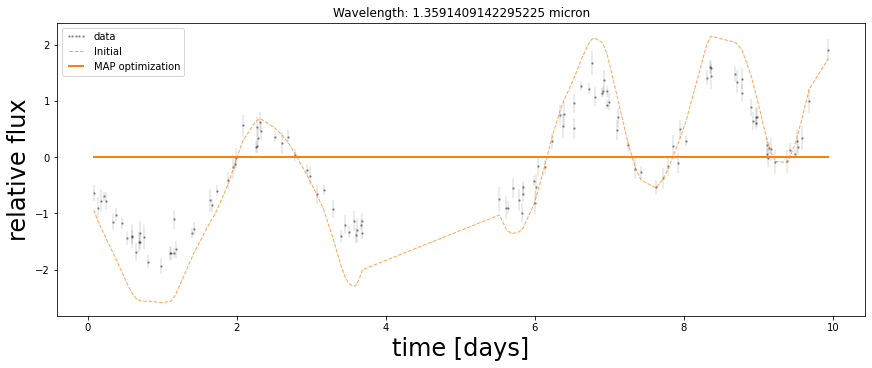

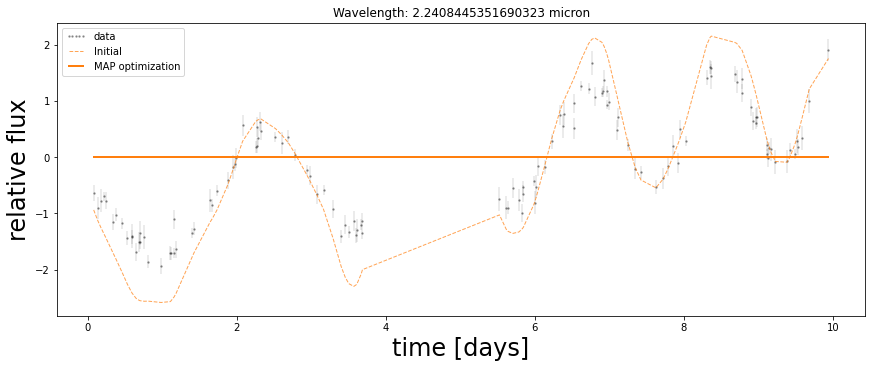

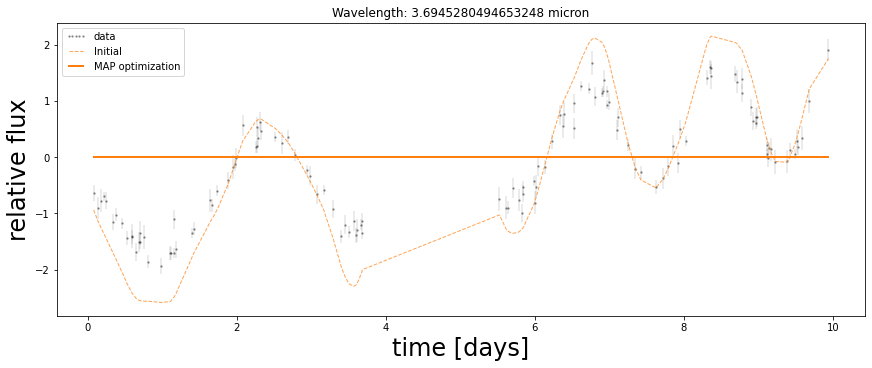

In [19]:
# optimize for initial values!
opt = p.optimize(plot=True)

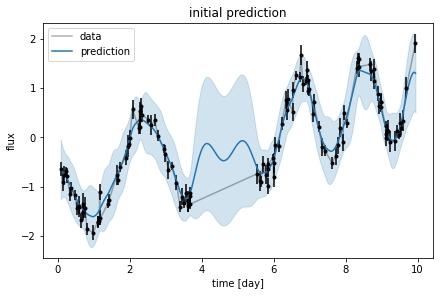

In [20]:
plt.title("initial prediction")
p.plot_prediction(p.gp[0])

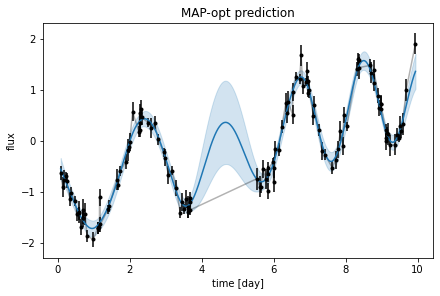

In [21]:
plt.title("MAP-opt prediction")
p.plot_prediction(p.generate_gp_model_from_params(params=opt), plot_var=True, legend=False)

In [22]:
# put those initial values into the sampling and define the number of tuning and draw steps, 
# as well as the number of chains.
p.sample(sampling_method=pmx.sample, start=opt, tune=2000, draws=4000, chains=4, cores=4, return_inferencedata=False)

Sampling model using the <function sample at 0x7fa4b8ae1b80> method


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nonperiodic_rho, nonperiodic_sigma, log_jitter, periodic_tau, periodic_rho, periodic_sigma]


/Users/catrionamurray/opt/anaconda3/lib/python3.9/site-packages/pymc3/step_methods/hmc/integration.py:108: RuntimeWarning: invalid value encountered in double_scalars
  energy = kinetic - logp
/Users/catrionamurray/opt/anaconda3/lib/python3.9/site-packages/pymc3/step_methods/hmc/integration.py:108: RuntimeWarning: invalid value encountered in double_scalars
  energy = kinetic - logp
Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 526 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
There were 741 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7795603040221365, but should be close to 0.9. Try to increase the number of tuning steps.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic 

                           mean         sd    hdi_16%     hdi_84%  mcse_mean   
periodic_sigma[0]      1.158955   0.468055   0.660906    1.330443   0.012931  \
periodic_sigma[1]      1.165766   0.475310   0.650757    1.310176   0.012767   
periodic_sigma[2]      1.158833   0.481849   0.659536    1.313052   0.013018   
periodic_sigma[3]      1.164457   0.480391   0.654874    1.309680   0.013101   
periodic_sigma[4]      1.159893   0.473437   0.635377    1.285631   0.012735   
periodic_rho[0]        2.020864   0.041023   1.978867    2.058879   0.000537   
periodic_tau[0]       21.046243  20.025734   5.256759   21.324715   0.653688   
log_jitter            -7.267150   1.025827  -7.824834   -6.107921   0.015849   
nonperiodic_sigma[0]  -1.618348   3.107640  -5.347181   -0.972685   1.368386   
nonperiodic_rho[0]    82.810034  46.768560  23.395489  104.090656   0.898868   

                       mcse_sd     ess_bulk     ess_tail     r_hat  
periodic_sigma[0]     0.009527  1674.422292  1775.

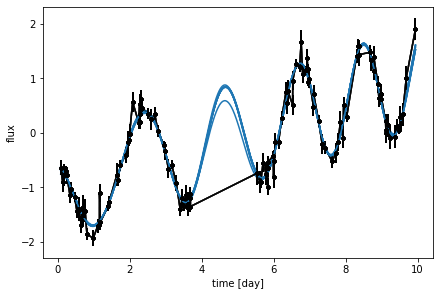

In [29]:
p.plot_traces(num_traces=10, i=0)

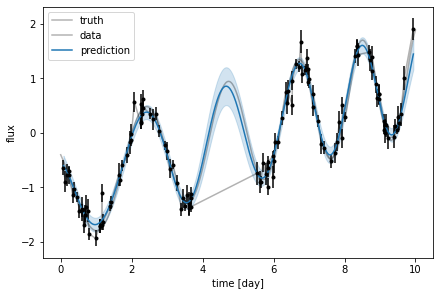

In [25]:
plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3,label="truth")
gp = p.generate_gp_model_from_params(p.summary['mean'])#new_results)
p.plot_prediction(gp)